Loading dataset with Gray-World + 3 Otsu variants per image...


Loading images (KMeans): 100%|█████████████████████████████████████████████████████| 1201/1201 [00:30<00:00, 39.00it/s]


Total images after expansion: 1201 (should be 3x original)
Preparing features...
Extracting deep features (MobileNet+Capsule)... this may take a while for large datasets

Extracting physical + GLCM features...
Training Random Forest...
Evaluating model...
Accuracy: 0.8464730290456431
Confusion Matrix:
[[75  0  6]
 [ 4 65 11]
 [ 9  7 64]]
Classification Report:
              precision    recall  f1-score   support

      INPARI       0.85      0.93      0.89        81
        IR16       0.90      0.81      0.86        80
   ROJO LELE       0.79      0.80      0.80        80

    accuracy                           0.85       241
   macro avg       0.85      0.85      0.85       241
weighted avg       0.85      0.85      0.85       241



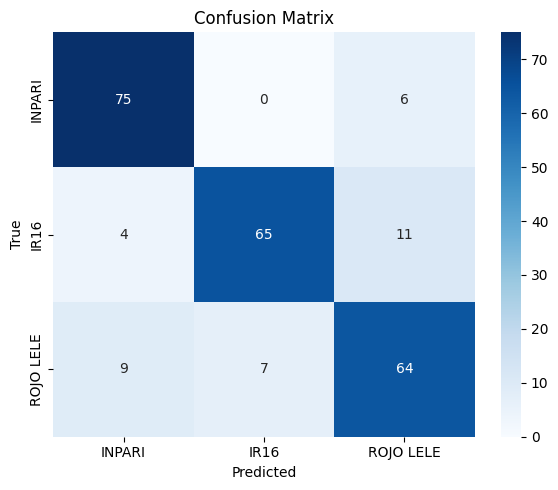

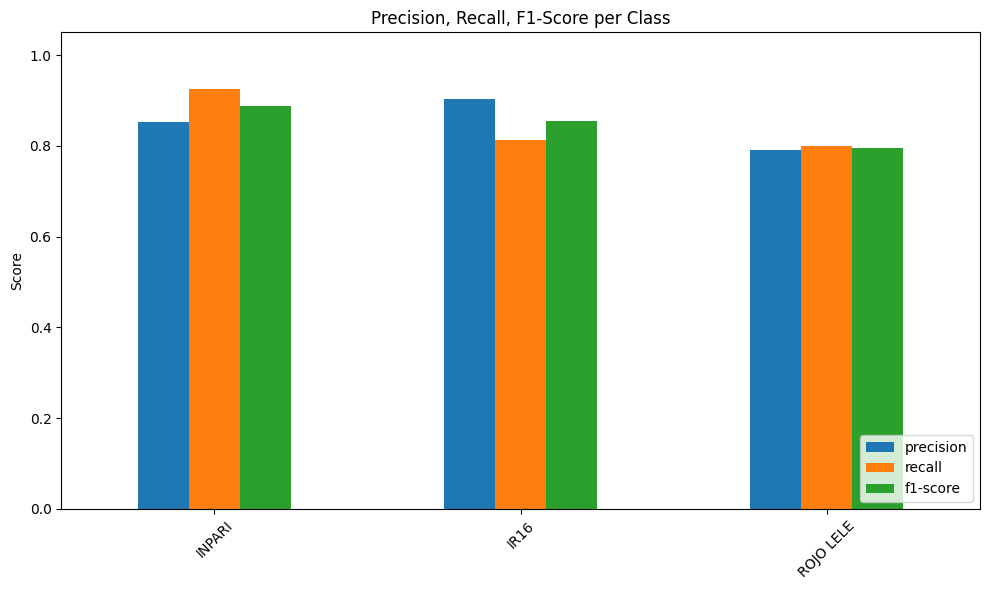

Done.


In [1]:
# Integrated pipeline: Gray-World + 3x Otsu variants + MobileNet+Capsule + RandomForest
# Choices made (from your selections):
# - Gray-World normalization applied (A1)
# - For each image we create 3 thresholded variants: Otsu, Otsu-Sinus, Otsu-Tangen (B1 label stays same)
# - Apply morphological opening after threshold (C1)
# - Integrate directly into load_dataset() (D1)
# - Stop program on any image read/process error (E2)
# - Add tqdm progress bar when loading dataset (F1)

import os
import cv2
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape, Lambda
from tensorflow.keras import backend as K

# --------------------- Utility: Gray-World Normalization ---------------------
def gray_world_normalization(img_color_float):
    # img_color_float expected as float32 BGR
    B, G, R = cv2.split(img_color_float)
    mean_R, mean_G, mean_B = np.mean(R), np.mean(G), np.mean(B)
    # avoid division by zero
    if mean_R == 0 or mean_G == 0 or mean_B == 0:
        raise RuntimeError("One of mean color channels is zero during Gray-World normalization")
    mean_gray = (mean_R + mean_G + mean_B) / 3.0
    R_corr = np.clip(R * (mean_gray / mean_R), 0, 255)
    G_corr = np.clip(G * (mean_gray / mean_G), 0, 255)
    B_corr = np.clip(B * (mean_gray / mean_B), 0, 255)
    img_corr = cv2.merge([B_corr, G_corr, R_corr]).astype(np.uint8)
    return img_corr

# --------------------- Otsu variations (work on grayscale histogram) ---------------------

def otsu_threshold_from_hist(hist):
    sum_total = np.dot(np.arange(256), hist)
    best_t = 0
    max_sigma = 0
    w0 = 0.0
    sum0 = 0.0
    for t in range(256):
        w0 += hist[t]
        sum0 += t * hist[t]
        if w0 == 0 or w0 == 1:
            continue
        w1 = 1 - w0
        mu0 = sum0 / w0
        mu1 = (sum_total - sum0) / w1
        sigma_b = w0 * w1 * (mu0 - mu1) ** 2
        if sigma_b > max_sigma:
            max_sigma = sigma_b
            best_t = t
    return best_t


def otsu_sinus_from_hist(hist):
    sum_total = np.dot(np.arange(256), hist)
    best_t, max_sigma = 0, 0
    w0, sum0 = 0.0, 0.0
    for t in range(256):
        w0 += hist[t]
        sum0 += t * hist[t]
        if w0 == 0 or w0 == 1:
            continue
        w1 = 1 - w0
        mu0 = sum0 / w0
        mu1 = (sum_total - sum0) / w1
        sigma_b = w0 * w1 * (math.sin(mu0 - mu1)) ** 2
        if sigma_b > max_sigma:
            max_sigma, best_t = sigma_b, t
    return best_t


def otsu_tangen_from_hist(hist):
    sum_total = np.dot(np.arange(256), hist)
    best_t, max_sigma = 0, 0
    w0, sum0 = 0.0, 0.0
    for t in range(256):
        w0 += hist[t]
        sum0 += t * hist[t]
        if w0 == 0 or w0 == 1:
            continue
        w1 = 1 - w0
        mu0 = sum0 / w0
        mu1 = (sum_total - sum0) / w1
        try:
            sigma_b = w0 * w1 * (math.tan(mu0 - mu1)) ** 2
        except (OverflowError, ValueError):
            sigma_b = 0
        if sigma_b > max_sigma:
            max_sigma, best_t = sigma_b, t
    return best_t

# --------------------- load_dataset: Gray-World + K-Means (replace Otsu variants) ---------------------
def load_dataset(dataset_path, morphology_kernel_size=3, kmeans_replace_mode=True):
    """Load dataset and for each image apply Gray-World normalization then K-Means (k=2) on RGB.
    This implementation replaces the previous Otsu variants: only the k-means mask is returned per image
    (as you chose Q1).
    """
    images_gray = []
    labels = []
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    if not classes:
        raise RuntimeError(f"No class directories found in {dataset_path}")

    kernel = np.ones((morphology_kernel_size, morphology_kernel_size), np.uint8)

    # iterate classes and files with progress bar
    total_files = 0
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        total_files += len(files)

    pbar = tqdm(total=total_files, desc="Loading images (KMeans)")

    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            # read color
            img_color = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img_color is None:
                pbar.close()
                raise RuntimeError(f"Image not found or unreadable: {img_path}")

            try:
                # Gray-world normalization
                img_color_float = img_color.astype(np.float32)
                img_norm = gray_world_normalization(img_color_float)

                # --- K-Means on RGB (P2) ---
                # reshape pixels for kmeans: (N,3)
                pixels = img_norm.reshape((-1, 3)).astype(np.float32)
                # criteria, attempts
                criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
                K = 2
                ret, labels_km, centers = cv2.kmeans(pixels, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
                if ret is None:
                    pbar.close()
                    raise RuntimeError(f"KMeans failed for image {img_path}")

                labels_km = labels_km.flatten()
                centers = centers.astype(np.float32)  # shape (K,3)

                # choose the cluster with the darkest mean intensity as foreground (F1)
                centers_intensity = centers.mean(axis=1)  # average of R,G,B per center
                fg_cluster = int(np.argmin(centers_intensity))  # darker cluster

                mask = (labels_km == fg_cluster).astype(np.uint8) * 255
                mask = mask.reshape((img_norm.shape[0], img_norm.shape[1]))

                # morphological opening (C1)
                clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

                # append single mask with same original label (B1)
                images_gray.append(clean_mask)
                labels.append(cls)

            except Exception as ex:
                pbar.close()
                raise

            pbar.update(1)

    pbar.close()
    return images_gray, labels

# --------------------- Physical features & GLCM ---------------------

def categorize_length_mm(length_mm):
    if 6.5 <= length_mm < 7.0:
        return "pendek"
    elif 7.0 <= length_mm <= 8.5:
        return "panjang"
    else:
        return "lainnya"

def categorize_area_cm2(area_cm2):
    if area_cm2 < 1.0:
        return "kecil"
    elif area_cm2 < 3.0:
        return "sedang"
    else:
        return "besar"


def extract_physical_features(img, pixels_per_cm, pixels_per_mm):
    features = []

    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)

        area_cm2 = cv2.contourArea(cnt) / (pixels_per_cm**2)
        perimeter_mm = cv2.arcLength(cnt, True) / pixels_per_mm
        length_mm = h / pixels_per_mm
        width_mm = w / pixels_per_mm
    else:
        area_cm2 = perimeter_mm = length_mm = width_mm = 0

    features.extend([area_cm2, perimeter_mm, length_mm, width_mm])

    # Area category one-hot
    area_mapping = {"kecil": [1,0,0], "sedang": [0,1,0], "besar": [0,0,1]}
    features.extend(area_mapping[categorize_area_cm2(area_cm2)])

    # Length category one-hot
    length_mapping = {"pendek": [1,0], "panjang": [0,1], "lainnya": [0,0]}
    features.extend(length_mapping[categorize_length_mm(length_mm)])

    # GLCM expects gray-level image (uint8)
    glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    features.extend([
        graycoprops(glcm, 'contrast')[0,0],
        graycoprops(glcm, 'dissimilarity')[0,0],
        graycoprops(glcm, 'homogeneity')[0,0],
        graycoprops(glcm, 'energy')[0,0],
        graycoprops(glcm, 'correlation')[0,0]
    ])
    return features

# --------------------- Capsule utilities ---------------------

def preprocess_image(img, target_size=(224,224)):
    img_resized = cv2.resize(img, target_size)
    img_resized = img_resized / 255.0
    return img_resized


def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


def create_capsule_layer(inputs, num_capsules=10, dim_capsule=16):
    u = Conv2D(filters=num_capsules*dim_capsule, kernel_size=3, strides=2, padding='valid', activation='relu')(inputs)
    u = Reshape(target_shape=[-1, dim_capsule])(u)
    u = Lambda(squash)(u)
    return u

# --------------------- Deep features (MobileNet + Capsule) ---------------------

def extract_deep_features(images):
    # images: numpy array of shape (N, H, W, 3) float32 in [0,1]
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    capsule_features = create_capsule_layer(x)
    features_model = Model(inputs=base_model.input, outputs=capsule_features)

    deep_features = features_model.predict(images, verbose=0)
    deep_features = deep_features.reshape(deep_features.shape[0], -1)
    return deep_features

# --------------------- Prepare dataset: combine deep + phys features ---------------------

def prepare_dataset(images_gray, labels, pixels_per_cm, pixels_per_mm):
    # images_gray: list/array of single-channel uint8 images (binary/masks)
    # convert to RGB for MobileNet (stack single channel)
    images_rgb = np.array([preprocess_image(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB).astype(np.float32)) for img in images_gray], dtype=np.float32)

    print("Extracting deep features (MobileNet+Capsule)... this may take a while for large datasets")
    deep_feats = extract_deep_features(images_rgb)

    print("Extracting physical + GLCM features...")
    phys_feats = np.array([extract_physical_features(img, pixels_per_cm, pixels_per_mm) for img in images_gray])

    # combine
    X = np.hstack([deep_feats, phys_feats])
    y = np.array(labels)
    return X, y

# --------------------- Train & evaluate ---------------------

def train_random_forest(X_train, y_train, n_estimators=100):
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    return rf


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_classes = df_report.iloc[:-3][['precision','recall','f1-score']]
    df_classes.plot(kind='bar', figsize=(10,6))
    plt.title("Precision, Recall, F1-Score per Class")
    plt.ylabel("Score")
    plt.ylim(0,1.05)
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# --------------------- Main ---------------------
if __name__ == '__main__':
    dataset_path = "C:/Users/naufal/jupyter/gabungan"  # adjust if needed
    pixels_per_cm = 50
    pixels_per_mm = pixels_per_cm / 10.0

    print("Loading dataset with Gray-World + 3 Otsu variants per image...")
    images_gray, labels = load_dataset(dataset_path)

    print(f"Total images after expansion: {len(images_gray)} (should be 3x original)")

    print("Preparing features...")
    X, y = prepare_dataset(images_gray, labels, pixels_per_cm, pixels_per_mm)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("Training Random Forest...")
    rf_model = train_random_forest(X_train, y_train)

    print("Evaluating model...")
    evaluate_model(rf_model, X_test, y_test)

    print("Done.")
